# Lecture des données 

Importation des bibliotheques 

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Avec la fonction read on va lire le dataset et le stocker dans df, `index_col=['DATE'] et parse_date = True` permettent d'indiquer a pandas que l'on travaille avec des series temporelles

In [ ]:
df = pd.read_csv("Frozen_Dessert_Production.csv", index_col='DATE', parse_dates=True)

`df.head() `permet d'afficher le debut du dataset

In [ ]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


on va renommer la colonne du dataset par production

In [ ]:
df.columns=['production']

On affiche le dataset en modifiant la taille du graphique avec `figsize`

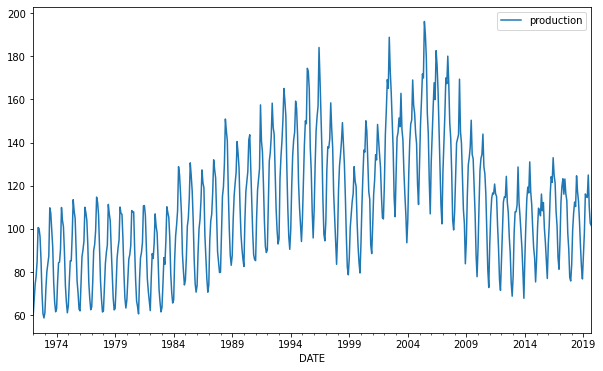

In [ ]:
df.plot(figsize=(10,6))

# Division des données en set de test et set d'entrainement 

On choisit de prendre les 24 dernieres lignes de notre dataset df pour notre set de test

Le set d'entrainement va donc contenir de la premiere a la  ( derniere - 24 eme ) ligne de notre dataset df

In [ ]:

test = df.iloc[-24:]
train = df.iloc[:(len(df)-24)]


On utilise la fonction `len()` pour determiner la longeur du dataset, on voit que la longeur de test est bien de 24, que la longeur de train est 549, donc 24 + 549 = 573 qui est la longueur de df

In [ ]:
print(len(df))
print(len(test))
print(len(train))

573
24
549


# Mise a l'echelle des données 

on importe les bibliotheque necessaire 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

On créer un scaler, puis on utilise `scaler.transform` pour transformer les données d'un dataset, puis les stocker dans une liste 

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)
#scaled_train

# Creation d'un generator


Un generator va creer un couple, il va prendre une sequence d'element ( de taille donnée ) de notre dataset et lui attribuer l'element suivant du dataset

**exemple de generator sur une suite de chiffres allant de 1 a 10**

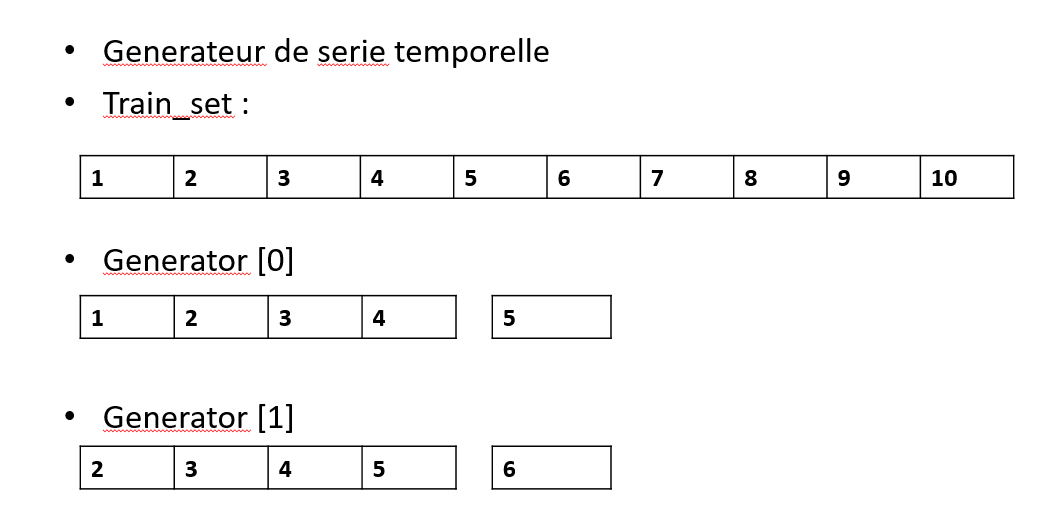

Comme un RNN predit une séquence, c est a dire qu'a partir d'une sequence donnée, le reseau va reussir a predire la suite, il faut creer ce generateur pour l'entrainer, et lui donner la sequence, et le resultat attendu

Dans le generateur creé si dessous,` length = 12, batch_size = 1` signifie qu on veut qu'il prenne 12 elements du tableau et qu'il lui associe 1 seul element

`scaled_train` est en argument car on lui demande de prendre 12 elements de `scaled_train`, et de leur associer un element provenant aussi de `scaled_train`

In [ ]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

generator = TimeseriesGenerator(scaled_train, scaled_train, length= 12, batch_size=1)


# Creation d'un modele

On importe les bibliotheques necessaires 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

On cree un model de type sequentiel, (la majorité des modeles sont sequentiels), on y ajoute une couche LSTM possédant 50 neuronnes ( ce parametre peut etre modifié ), nous choisissont une fonction d'activation 'relu', il existe de nombreuses fonctions d'activation, relu est la plus adaptée dans notre cas, pour savoir quelle fonction choisir, il suffit de faire quelques recherches sur internet, on precise la shape de l'entrée, en l'occurence notre couche LSTM va recevoir 12 valeur d'une sequence, et une valeur qui correspond a la suite de la séqunce ( valeur a predire ) 


On ajuote une couche Dense avec 1 neuronne, car il y a une seule valeur a predire 
Enfin on compile en ajoutant un optimizer, nous avons choisit adam, cet optimizer depend de l'utilisation du reseaux de neuronnes. Comme loss nous avons choisit mse, la loss calcule les erreurs de prediction du modele, mse calcule l'erreur moyenne

In [ ]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(12,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')


On entraine ensuite notre modele, on lui donne comme valeurs sur lesquels s entrainner : notre générateur, et on lui demande de s'entrainner sur 5 epochs, une epochs represente un parcours entier du dataset, c'est a dire que le modele va s'entrainner sur toutes las valeurs du dataset en ajustant les poids des neuronnes a chaque fois, 

In [ ]:
model.fit(generator, epochs=5)

Epoch 1/5
537/537 [==============================] - 3s 4ms/step - loss: 0.0451
Epoch 2/5
537/537 [==============================] - 2s 4ms/step - loss: 0.0111
Epoch 3/5
537/537 [==============================] - 2s 4ms/step - loss: 0.0062
Epoch 4/5
537/537 [==============================] - 2s 4ms/step - loss: 0.0049
Epoch 5/5
537/537 [==============================] - 2s 4ms/step - loss: 0.0037


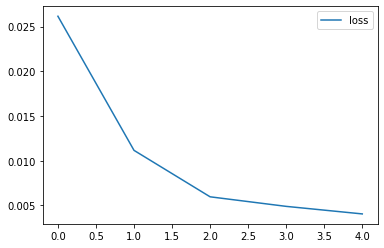

In [ ]:
loss = pd.DataFrame(model.history.history)
loss.plot()

In [ ]:
test_pred=[]
first_batch = scaled_train[-12:]
current_batch = first_batch.reshape(1, 12, 1)

for i in range(len(test)):
  prediction = model.predict(current_batch)[0]
  test_pred.append(prediction)
  current_batch=np.append(current_batch[:,1:,:],[[prediction]], axis = 1)


In [ ]:
test_pred = scaler.inverse_transform(test_pred)
test_pred

array([[ 90.66630756],
       [ 87.62602888],
       [ 90.09691538],
       [ 95.8388398 ],
       [102.53752963],
       [108.48668123],
       [112.89084795],
       [114.61944599],
       [114.12305564],
       [108.14463446],
       [ 99.45439163],
       [ 90.04445185],
       [ 84.69955405],
       [ 83.71357643],
       [ 86.11512491],
       [ 90.9889533 ],
       [ 96.76670447],
       [102.4696342 ],
       [106.70662987],
       [108.09000911],
       [105.49763867],
       [ 99.02197881],
       [ 90.77511567],
       [ 83.26363341]])

In [ ]:
test['prediction'] = test_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test

,production,prediction
DATE,,
2017-10-01,90.4732,90.666308
2017-11-01,77.4378,87.626029
2017-12-01,75.8118,90.096915
2018-01-01,83.4343,95.838840
2018-02-01,99.4899,102.537530
2018-03-01,107.3152,108.486681
2018-04-01,112.4309,112.890848
2018-05-01,110.3544,114.619446
2018-06-01,124.5841,114.123056


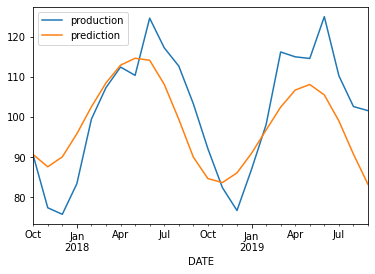

In [ ]:
test.plot()

In [ ]:
full_scaler = MinMaxScaler()


In [ ]:
scaled_data = scaler.fit_transform(df)

In [ ]:
generator = TimeseriesGenerator(scaled_data, scaled_data, 12, 1)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(12,1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.fit(generator, epochs=20)

Epoch 1/20
5/5 [==============================] - 1s 21ms/step - loss: 0.2458
Epoch 2/20
5/5 [==============================] - 0s 23ms/step - loss: 0.2027
Epoch 3/20
5/5 [==============================] - 0s 21ms/step - loss: 0.1554
Epoch 4/20
5/5 [==============================] - 0s 20ms/step - loss: 0.1079
Epoch 5/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0463
Epoch 6/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0356
Epoch 7/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0269
Epoch 8/20
5/5 [==============================] - 0s 21ms/step - loss: 0.0253
Epoch 9/20
5/5 [==============================] - 0s 20ms/step - loss: 0.0245
Epoch 10/20
5/5 [==============================] - 0s 22ms/step - loss: 0.0295
Epoch 11/20
5/5 [==============================] - 0s 23ms/step - loss: 0.0214
Epoch 12/20
5/5 [==============================] - 0s 24ms/step - loss: 0.0203
Epoch 13/20
5/5 [==============================] - 0s 23ms/st

In [ ]:
forecast=[]
first_batch=scaled_data[-12:]
current_batch = first_batch.reshape(1,12,1)

for i in range ( 12 ):
  prediction = model.predict(current_batch)[0]
  forecast.append(prediction)
  current_batch=np.append(current_batch[:,1:,:], [[prediction]], axis=1)

In [ ]:
forecast = scaler.inverse_transform(forecast)
forecast

array([[101.55730183],
       [100.5555583 ],
       [101.22239418],
       [103.70680485],
       [106.45978506],
       [108.63558235],
       [109.28153364],
       [109.27738622],
       [108.42006854],
       [106.03129015],
       [104.95639725],
       [104.62850578]])

In [ ]:
df

,production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636
...,...
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632


In [ ]:
forecast_ind = pd.date_range(start = '2019-10-01', periods=12, freq='MS')
forecast_df = pd.DataFrame(data = forecast, index=forecast_ind, columns=['forecast'])

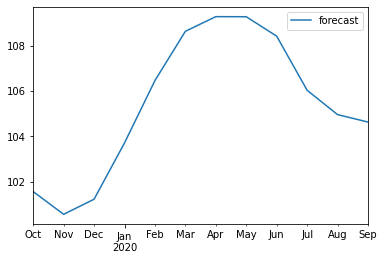

In [ ]:
forecast_df.plot()

(576.0, 608.0)

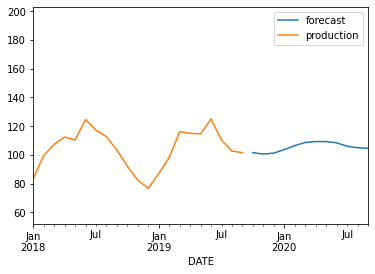

In [ ]:
ax = forecast_df.plot()
df.plot(ax=ax)
plt.xlim('2018-01-01', '2020-09-01')